# Homotopic optimal control of interplanetary spacecraft

## Dynamics

In [1]:
from sympy import *
init_printing()

In [2]:
# state variables
x, y, z, vx, vy, vz = symbols('x y z v_x v_y v_z', real=True)
m = symbols('m', real=True, nonnegative=True)

# position
p = Matrix([x, y, z])

# velocity
v = Matrix([vx, vy, vz])

# state
s = Matrix([p, v, [m]])
s.T

[x  y  z  vₓ  v_y  v_z  m]

In [3]:
# control parameters
um = symbols('u', real=True, positive=True)
ux, uy, uz =symbols('\\hat{u}_x \\hat{u}_y \\hat{u}_z', real=True)
uh = Matrix([ux, uy, uz])
u = Matrix([[um], uh])

# constants
c1, c2, mu = symbols('c_1 c_2 \\mu', real=True, positive=True)
T, isp, mu, g = symbols('T I_{sp} \\mu g_0', real=True, positive=True)
c1 = T
c2 = T/(isp*g)

# equations of motion
ds = Matrix([
    v,
    (-mu/((x**2 + y**2 + z**2)**(Rational(3/2))))*(p) + (c1*um/m)*uh,
    [-c2*um]
])
simplify(ds)

⎡               vₓ                ⎤
⎢                                 ⎥
⎢               v_y               ⎥
⎢                                 ⎥
⎢               v_z               ⎥
⎢                                 ⎥
⎢T⋅\hat{u}ₓ⋅u         \mu⋅x       ⎥
⎢──────────── - ───────────────── ⎥
⎢     m                       3/2 ⎥
⎢               ⎛ 2    2    2⎞    ⎥
⎢               ⎝x  + y  + z ⎠    ⎥
⎢                                 ⎥
⎢T⋅\hat{u}_y⋅u         \mu⋅y      ⎥
⎢───────────── - ─────────────────⎥
⎢      m                       3/2⎥
⎢                ⎛ 2    2    2⎞   ⎥
⎢                ⎝x  + y  + z ⎠   ⎥
⎢                                 ⎥
⎢T⋅\hat{u}_z⋅u         \mu⋅z      ⎥
⎢───────────── - ─────────────────⎥
⎢      m                       3/2⎥
⎢                ⎛ 2    2    2⎞   ⎥
⎢                ⎝x  + y  + z ⎠   ⎥
⎢                                 ⎥
⎢              -T⋅u               ⎥
⎢            ─────────            ⎥
⎣            I_{sp}⋅g₀            ⎦

In [4]:
# homotopy parameter
alpha, beta = symbols('\\alpha \\beta', real=True, nonnegative=True)

# Lagrangian
L = alpha + (1-alpha)*um
L = beta*L + (1-beta)*um**2
L.simplify()

In [5]:
 # costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True)
l.T

[\lambda_{x}  \lambda_{y}  \lambda_{z}  \lambda_{v_x}  \lambda_{v_y}  \lambda_
{v_z}  \lambda_{m}]

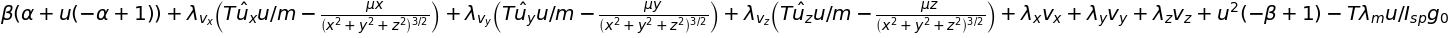

In [6]:
# Hamiltonian
H = l.dot(ds) + L
H

In [7]:
# minimise Hamiltonian w.r.t. controls
lv = Matrix(l[3:6])
uhs = -lv/sqrt(sum([var**2 for var in lv]))
simplify(uhs)

⎡                   -\lambda_{v_x}                    ⎤
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_y}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_z}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎣╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎦

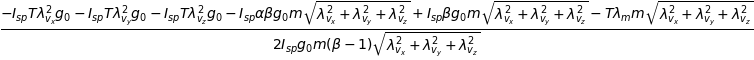

In [8]:
# new Hamiltonian
H1 = H.subs(ux, uhs[0]).subs(uy, uhs[1]).subs(uz, uhs[2])
ums = solve(H1.diff(um), um)[0]
ums

In [9]:
lv = symbols('\lambda_v')

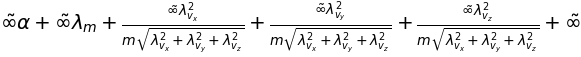

In [10]:
ums.subs(beta, 1).simplify()

$$
\frac{1}{2(1-\beta)}
\left(
\frac{T \left(\pmb{\lambda}_v \cdot \pmb{\lambda}_v\right)}{ \lambda_v  m }
+
\frac{T \lambda_{m} }{ I_{sp}  g_{0} } +
\beta  \left(\alpha - 1\right)
\right)
$$

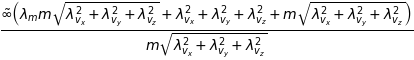

In [11]:
ums.subs(beta, 1).subs(alpha, 0).simplify()

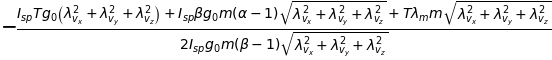

In [12]:
ums.simplify().collect(isp*T*g).collect(beta*isp*g*m).collect(sqrt(sum(var**2 for var in l[3:6]))).simplify()

$$
\frac{
    -I_{sp} T g_0 \left( \pmb{\lambda}_v \cdot \pmb{\lambda}_v \right)
    + \lambda_v I_{sp} g_0 m \beta (1- \alpha)
    - \lambda_v \lambda_m T m
}{
    2 \lambda_v I_{sp} g_0 m (\beta -1)
}
$$

$$
\frac{1}{2(\beta - 1)}
\left(
\beta (1- \alpha)
-
\frac{
    T \left( \pmb{\lambda}_v \cdot \pmb{\lambda}_v \right)
}{
    \lambda_v  m 
} 
-
\frac{
      \lambda_m T 
}{
      I_{sp} g_0 
}
\right)
$$

$$
\frac{
    -I_{sp} T g_0 \left( \pmb{\lambda}_v \cdot \pmb{\lambda}_v \right)
    + \lambda_v I_{sp} g_0 m \left( 1 - \alpha \right)
    - T \lambda_m m \lambda_v
}{
    m \lambda_v
}
$$

In [13]:
us = Matrix([[ums], uhs])

In [ ]:
# costate equations of motion
dl = -H.diff(s)
dl

In [ ]:
Matrix([
    ums.subs(alpha, 0).subs(beta, 0),
    ums.subs(alpha, 0).subs(beta, 1),
    ums.subs(alpha, 1).subs(beta, 0),
    ums.subs(alpha, 1).subs(beta, 1),
    ums.subs(alpha, 0),
    ums.subs(alpha, 1),
    ums.subs(beta, 0),
    ums.subs(beta, 1),
    ums
])

In [ ]:
tangent = Matrix([
    (-mu/(p.norm()**3))*p,
    v
])
tangent = tangent/tangent.norm()
l[:-1, :].dot(tangent).simplify().collect()

In [ ]:
# regular optimal control
ums.subs(beta, 1).simplify().subs(sqrt(sum([var**2 for var in l[3:6]])), '\lambda_v')

$$
\frac{\pmb{\lambda}_v \cdot \pmb{\lambda}_v}{\lambda_v m} + \lambda_m + 1 + \alpha
$$

In [ ]:
# effort optimal control
ums.subs(beta, 1).subs(alpha, 0).simplify().subs(sqrt(sum([var**2 for var in l[3:6]])), '\lambda_v')

$$
\frac{\pmb{\lambda}_v \cdot \pmb{\lambda}_v}{\lambda_v m}
+
\lambda_m
+
1
$$

In [ ]:
# time optimal control
ums.subs(beta, 1).subs(alpha, 1).simplify().subs(sqrt(sum([var**2 for var in l[3:6]])), '\lambda_v')

In [ ]:
# effort or time optimal control

$$
\frac{\pmb{\lambda}_v \cdot \pmb{\lambda}_v}{\lambda_v m}
+
\lambda_m
$$

$$
\frac{\mu}{r^3} \pmb{\lambda}_v - \frac{3\mu}{r^5}\left( \pmb{\lambda}_v \cdot \pmb{r} \right)
$$

tangent

## Base trajectory

In [14]:
import sys, numpy as np, matplotlib.pyplot as plt, pygmo as pg, pykep as pk
sys.path.append('../src/')
from spacecraft import Spacecraft
from indirect import Indirect
%matplotlib

Using matplotlib backend: TkAgg


In [15]:
# instantiate problem
seg = Spacecraft(T=0.2, isp=2500, m=1000)

In [16]:
# initial state
s0 = np.hstack((*pk.planet.jpl_lp('earth').eph(pk.epoch(0)), seg.M))

# homotopy parameters
alpha = 0
seg.beta = 0

# duration bounds in days
Tlb = 100
Tub = 500

# costates bounds
lb = 50

# decision vector guess
zg = [379.20912013,   0.93398202,  12.76567896, -45.55493263,  -8.26940351, 49.99989562, 3.00127225, -8.58992837, 8.32972382]

In [17]:
# solve single trajectory
z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)

# solve multiple candidate trajectories in parallel
#zl, fl, feasl = seg.solve_par(s0, alpha, 200, 450, 50, npar=1000)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


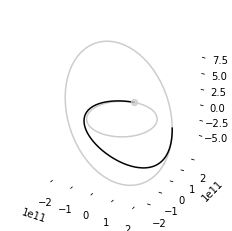

In [18]:
# plot trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
ax = seg.plot_traj(sl, alpha=1)
plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 0$

In [19]:
# homotopy
alpha = 0
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta0 = np.load('spacecraft_z_beta_homotopy_alpha_0.npy'); alpha = 0

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 432x288 with 0 Axes>

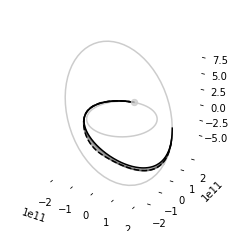

In [20]:
# plot homotopy
fig = plt.figure()
for i, t in enumerate(Ta0):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta0) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 1$

In [21]:
# homotopy
alpha = 1
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta1 = np.load('spacecraft_z_beta_homotopy_alpha_1.npy'); alpha = 1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


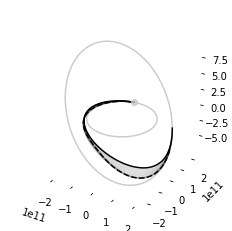

In [22]:
# plot homotopy
for i, t in enumerate(Ta1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
ax1 = ax
plt.show()

# Policy homotopy in $\alpha \times [0, 1] : \beta = 1$

In [23]:
# homotopy
alpha = 0
alphag = 1
seg.beta = 0.99999
z = Ta0[-1][0]
#Tb1 = seg.homotopy(s0, alpha, Tlb, Tub, lb, z, alphag, step=0.1, verbose=False)
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


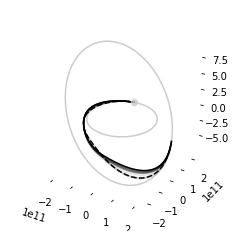

In [24]:
# plot homotopy
for i, t in enumerate(Tb1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    alpha = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Tb1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
ax2 = ax
plt.show()

## Comparing policy homotopies

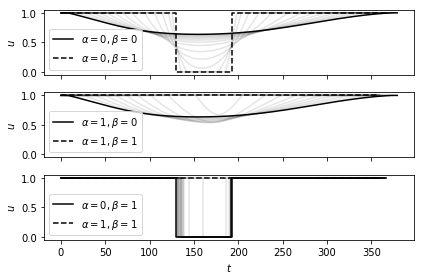

In [26]:
# figure
fig, ax = plt.subplots(3, sharex=True)

alpha = 0
for i, sol in enumerate(Ta0):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta0) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta0) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
    
alpha = 1
for i, sol in enumerate(Ta1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta1) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta1) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
        
seg.beta = 0.999999999
for i, sol in enumerate(Tb1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    alpha = sol[1]
    
    # simulate
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[2].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    elif i == len(Tb1) - 1:
        ax[2].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[2].plot(tl, ul[:,0], "k-", alpha=0.1)
    

ax[2].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$u$')
ax[1].set_ylabel(r'$u$')
ax[2].set_ylabel(r'$u$')
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[2].legend(loc='lower left')
ax[0].set_ylim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.05)
ax[2].set_ylim(-0.05, 1.05)

fig.tight_layout()
#fig.savefig('spacecraft_u_full_homotopy.pdf', bbox_inches='tight')
plt.show()

## Random walks at $\beta = 0$

In [27]:
# decision vector and homotopy parameter
z, seg.beta = Ta0[0]
alpha = 0

# number of serial perturbations per walk
n = 1

# number of walks
nw = 8

In [ ]:
# random walks in parallel
T = seg.random_walk_par(s0, z, alpha, n, Tlb, Tub, lb, nw, dsm=0.001, verbose=True)

In [28]:
# plot random walks
for i, t in enumerate(T):
    s0 = t[0]
    z = t[1]
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.5)
plt.show()

TypeError: 'Symbol' object is not iterable

## Database homotopy $\beta \times [0, 1], \alpha = 0$

In [29]:
#res = seg.homotopy_db_beta(T, alpha, beta, Tlb, Tub, lb, betag, step=0.1)
res = np.load('spacecraft_db_beta_homotopy_a0.npy')

In [30]:
#np.save('spacecraft_db_beta_homotopy_a0.npy', res)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


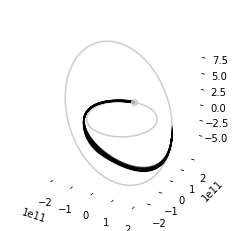

In [31]:
# plot database homotopy
alpha = 0
for i, r in enumerate(res):
    s0, z, seg.beta = r
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=0.1)
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.1)
plt.show()

## Database homotopy $\alpha \times [0, 1], \beta = 1$

In [32]:
# get effort optimal trajectories
s0zl = res[np.argwhere(res[:,2] >= 0.999).flatten(), :2]
alpha = 0
alphag = 1
seg.beta == 0.99999
#T = seg.homotopy_db(s0zl, alpha, Tlb, Tub, lb, alphag, step=0.01)
T = np.load('spacecraft_db_alpha_homotopy_beta_1.npy')

In [33]:
#np.save('spacecraft_db_alpha_homotopy_beta_1.npy', T)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


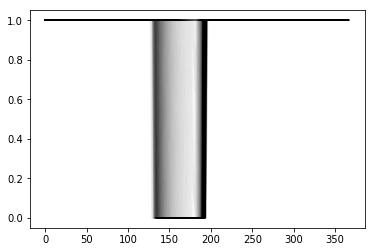

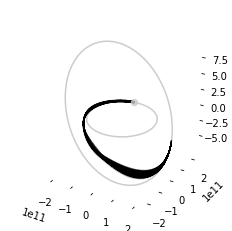

In [34]:
# plot database homotopy
fig1, ax1 = plt.subplots(1)
for i, r in enumerate(T):
    s0, z, alpha = r
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    ax1.plot(tl, ul[:,0], "k-", alpha=0.01)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=0.01)
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.01)
        
#fig.savefig('spacecraft_s_alpha_homotopy_db.pdf', bbox_inches='tight')
plt.show()

## Training a neural network

In [35]:
from ann import *

In [42]:
# assemble database
#db = seg.gen_db(T, cat=True)
db = np.load('spacecraft_db.npy')
db = db[np.hstack((np.argwhere(db[:,8] == 1).flatten(), np.argwhere(db[:,8] == 0).flatten())), :]

In [37]:
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy'); seg.beta = 0.9999
db = list()
for r in Tb1:
    z, alpha = r
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True, atol=1e-14, rtol=1e-14)
    d = np.hstack((
        sl[:, :seg.sdim],
        np.full((len(sl), 1), alpha),
        ul.reshape(-1, seg.udim)
    ))
    db.append(d)
db = np.vstack(db)
db = db[np.hstack((np.argwhere(db[:,8] == 1).flatten(), np.argwhere(db[:,8] == 0).flatten())), :]

/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:38: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


In [ ]:
#np.save('spacecraft_db.npy', db)

In [43]:
# get data ready for training 
#db = Data(db, [0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11])
db = Data(db, [0, 1, 2, 3, 4, 5, 6, 7], [8])

In [44]:
# instantiate the neural network
#mlp = Spacecraft_Controller([seg.sdim + 1, 20, 20, 20, 20, 20, 20, 4])
mlp = Spacecraft_Throttle_Controller([seg.sdim + 1, 20, 20, 1])

In [45]:
mlp.train(db.i, db.o, epo=500, lr=1e-3, ptst=0.1, gpu=False)

Episode 0; Testing Loss 0.1849045268993733; Training Loss 0.18523875953513622
Episode 1; Testing Loss 0.18025235908099668; Training Loss 0.1806162817487865
Episode 2; Testing Loss 0.1760882603847477; Training Loss 0.17648062140613607
Episode 3; Testing Loss 0.17240248062000862; Training Loss 0.17282196444277714
Episode 4; Testing Loss 0.16917892582536526; Training Loss 0.1696241599316657
Episode 5; Testing Loss 0.16639530399713973; Training Loss 0.16686487498652022
Episode 6; Testing Loss 0.16402360634129817; Training Loss 0.16451607058095644
Episode 7; Testing Loss 0.1620309032642127; Training Loss 0.1625447962711131
Episode 8; Testing Loss 0.16038042698780994; Training Loss 0.16091427235188416
Episode 9; Testing Loss 0.1590328304019329; Training Loss 0.15958514884165895
Episode 10; Testing Loss 0.1579475730649265; Training Loss 0.15851689217209414
Episode 11; Testing Loss 0.15708436692616787; Training Loss 0.15766923163091076
Episode 12; Testing Loss 0.15640452020789883; Training Los

Episode 104; Testing Loss 0.12399916039787814; Training Loss 0.1247153250927874
Episode 105; Testing Loss 0.12369541043256464; Training Loss 0.12441172541352179
Episode 106; Testing Loss 0.1233944405615419; Training Loss 0.12411085491709867
Episode 107; Testing Loss 0.1230962031750514; Training Loss 0.12381267021910923
Episode 108; Testing Loss 0.12280064857019873; Training Loss 0.12351712485302452
Episode 109; Testing Loss 0.12250772663024938; Training Loss 0.12322417076518492
Episode 110; Testing Loss 0.12221738797831305; Training Loss 0.12293375934000844
Episode 111; Testing Loss 0.12192958455177975; Training Loss 0.12264584190757452
Episode 112; Testing Loss 0.12164426963628756; Training Loss 0.12236036977614721
Episode 113; Testing Loss 0.12136139747447368; Training Loss 0.12207729390608732
Episode 114; Testing Loss 0.12108092261522531; Training Loss 0.12179656438930002
Episode 115; Testing Loss 0.12080279918800531; Training Loss 0.12151812991419013
Episode 116; Testing Loss 0.120

Episode 206; Testing Loss 0.10108900284537775; Training Loss 0.10152735074809023
Episode 207; Testing Loss 0.10091893911529304; Training Loss 0.10135279787994193
Episode 208; Testing Loss 0.10075015386074732; Training Loss 0.10117950645549723
Episode 209; Testing Loss 0.10058266806314543; Training Loss 0.10100749863310261
Episode 210; Testing Loss 0.1004165030086078; Training Loss 0.10083679672324683
Episode 211; Testing Loss 0.10025168038831593; Training Loss 0.10066742315694889
Episode 212; Testing Loss 0.10008822233982395; Training Loss 0.10049940045300554
Episode 213; Testing Loss 0.09992615141500426; Training Loss 0.10033275118308849
Episode 214; Testing Loss 0.09976549047462425; Training Loss 0.10016749793438451
Episode 215; Testing Loss 0.09960626252396433; Training Loss 0.1000036632707328
Episode 216; Testing Loss 0.0994484905152964; Training Loss 0.09984126969354692
Episode 217; Testing Loss 0.09929219714896405; Training Loss 0.09968033960345699
Episode 218; Testing Loss 0.099

Episode 308; Testing Loss 0.09215692715216756; Training Loss 0.09217362588558187
Episode 309; Testing Loss 0.09214098645743023; Training Loss 0.09215526338608077
Episode 310; Testing Loss 0.09212571397463754; Training Loss 0.09213761426658659
Episode 311; Testing Loss 0.09211108721300179; Training Loss 0.09212065572634333
Episode 312; Testing Loss 0.09209708412206855; Training Loss 0.0921043653682612
Episode 313; Testing Loss 0.09208368308718935; Training Loss 0.09208872120883073
Episode 314; Testing Loss 0.09207086292231546; Training Loss 0.09207370168729997
Episode 315; Testing Loss 0.0920586028672868; Training Loss 0.09205928567334487
Episode 316; Testing Loss 0.09204688259349161; Training Loss 0.0920454524741574
Episode 317; Testing Loss 0.09203568221771014; Training Loss 0.09203218184021406
Episode 318; Testing Loss 0.09202498231950755; Training Loss 0.09201945397022522
Episode 319; Testing Loss 0.09201476395615915; Training Loss 0.09200724951507705
Episode 320; Testing Loss 0.092

Episode 410; Testing Loss 0.09179423959696868; Training Loss 0.09171865859304737
Episode 411; Testing Loss 0.09179347029634355; Training Loss 0.09171779697921045
Episode 412; Testing Loss 0.09179269750088478; Training Loss 0.09171693732745108
Episode 413; Testing Loss 0.09179192113991468; Training Loss 0.0917160794071364
Episode 414; Testing Loss 0.09179114115333772; Training Loss 0.0917152230021613
Episode 415; Testing Loss 0.09179035749070223; Training Loss 0.09171436791006018
Episode 416; Testing Loss 0.09178957011033456; Training Loss 0.09171351394122866
Episode 417; Testing Loss 0.09178877897858224; Training Loss 0.09171266091814054
Episode 418; Testing Loss 0.09178798406920259; Training Loss 0.09171180867464429
Episode 419; Testing Loss 0.09178718536287948; Training Loss 0.09171095705526365
Episode 420; Testing Loss 0.09178638284677945; Training Loss 0.09171010591456913
Episode 421; Testing Loss 0.09178557651408699; Training Loss 0.09170925511655346
Episode 422; Testing Loss 0.09

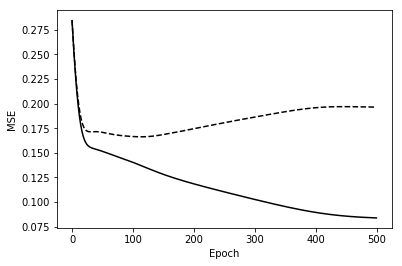

In [41]:
fig, ax = plt.subplots(1)
ax.plot(mlp.ltrn, "k-")
ax.plot(mlp.ltst, "k--")
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
#ax.set_xscale('log')
plt.show()

## Neural network accuracy

In [ ]:
mlp.cpu()
# alpha homotopy
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy'); seg.beta = 0.9999

# effort optimal base
z = Tb1[0][0]
alpha = 0
tl0, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
a0i = np.hstack((sl[:,:seg.sdim], np.full((len(sl), 1), alpha)))
a0o = ul
a0op = mlp(torch.from_numpy(a0i)).detach().numpy()

# time optimal base
z = Tb1[-1][0]
alpha = 1
tl1, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
a1i = np.hstack((sl[:,:seg.sdim], np.full((len(sl), 1), alpha)))
a1o = ul
a1op = mlp(torch.from_numpy(a1i)).detach().numpy()

In [ ]:
# plot
fig, ax = plt.subplots(4, 2, sharex=True, sharey=False)
for i in range(4):
    ax[i][0].plot(tl0, a0o[:, i], "k--")
    ax[i][1].plot(tl1, a1o[:, i], "k--")
    ax[i][0].plot(tl0, a0op[:, i], "k-")
    ax[i][1].plot(tl1, a1op[:, i], "k-")
    if i == 0:
        ax[i][0].set_ylim(-0.1, 1.1)
        ax[i][1].set_ylim(-0.1, 1.1)
    else:
        ax[i][0].set_ylim(-1.1, 1.1)
        ax[i][1].set_ylim(-1.1, 1.1)

fig.tight_layout()
plt.show()

In [ ]:
a1i[0]